In [172]:
# BASIC DS LIBS
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# FILE IO LIBS
import os 
from os.path import join 

# GEOSPATIAL LIBS
from osgeo import gdal
import geopandas as gpd
import geopy
from geopandas import GeoDataFrame

# PLOT LIBS
import plotly.express as px 
from plotly.offline import plot
import plotly.graph_objects as go
from shapely.geometry import Point
from plotly.subplots import make_subplots


In [173]:
# IMPORT DATA
hunger_data = pd.read_csv(r'data/foodlink_data.csv')
mealmap_data = pd.read_excel(r'data/MMG2022_2020-2019Data_ToShare.xlsx')
gun_data = pd.read_csv(r'data/Rochester_NY_Shooting_Victims.csv')

## EDA

### DATA CLEANING

##### REMOVING EXCESS VARIABLES AND OBJECTS

In [174]:
gun_data.head()
print(gun_data.columns)
print(gun_data.count())

Index(['X', 'Y', 'ID', 'Case_Number', 'Address', 'Occurred_Date',
       'Occurred_Month', 'Occurred_Year', 'Crime_Type', 'Multiple_Shooting',
       'Gender', 'Race', 'Ethnicity', 'Victim_Age', 'Victim_Age_Band',
       'Latitude', 'Longitude', 'ObjectId'],
      dtype='object')
X                    4679
Y                    4679
ID                   4679
Case_Number          4679
Address              4679
Occurred_Date        4679
Occurred_Month       4679
Occurred_Year        4679
Crime_Type           4679
Multiple_Shooting    4679
Gender               4679
Race                 4679
Ethnicity            4679
Victim_Age           4679
Victim_Age_Band      4679
Latitude             4679
Longitude            4679
ObjectId             4679
dtype: int64


In [175]:
# GUN DATA CLEANING
gun_data = gun_data.drop(columns=[
                        'ID',
                        'Case_Number',
                        'Occurred_Month',
                        'Gender',
                        'Race',
                        'Ethnicity',
                        'Victim_Age',
                        'Victim_Age_Band',
                        'ObjectId',
                        'Crime_Type',
                        'Multiple_Shooting'
                        ])

gun_data = gun_data.loc[gun_data['Occurred_Year'].isin([2022,2023])]                        
print(gun_data.info())  # to check for any missing values
print("                           GUN VIOLENCE DATA AFTER DATA CLEANING")
gun_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 436
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              137 non-null    float64
 1   Y              137 non-null    float64
 2   Address        137 non-null    object 
 3   Occurred_Date  137 non-null    object 
 4   Occurred_Year  137 non-null    int64  
 5   Latitude       137 non-null    float64
 6   Longitude      137 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 8.6+ KB
None
                           GUN VIOLENCE DATA AFTER DATA CLEANING


,X,Y,Address,Occurred_Date,Occurred_Year,Latitude,Longitude
0,-77.610890,43.184163,442 Remington St,2022/06/01 04:00:00+00,2022,43.184163,-77.610890
1,-77.598893,43.181793,904 Hudson Ave,2022/05/29 04:00:00+00,2022,43.181793,-77.598893
2,-77.630378,43.142970,168 Bartlett St,2022/05/29 04:00:00+00,2022,43.142970,-77.630378
3,-77.580628,43.167216,720 N Goodman St,2022/05/28 04:00:00+00,2022,43.167216,-77.580628
4,-77.641972,43.162394,138 Murray St,2022/05/26 04:00:00+00,2022,43.162394,-77.641972


In [180]:
# HUNGER DATA
hunger_data.columns = ['Zip_Code', 'Latitude', 'Longitude', 'Food Insecurity']

# NARROW DOWN DATA TO JUST ROCHESTER AREAS
roc_zip = list(range(14604, 14624))
roc_zip.append(14626)
roc_zip.append(14627)
roc_zip.append(14642)
hunger_data = hunger_data.loc[hunger_data['Zip_Code'].isin(roc_zip)]

print(hunger_data.info())   # to check for missing values

print("     FOOD INSECURITY DATA AFTER DATA CLEANING")
hunger_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 124 to 145
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Zip_Code         20 non-null     int64  
 1   Latitude         20 non-null     float64
 2   Longitude        20 non-null     float64
 3   Food Insecurity  20 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 800.0 bytes
None
     FOOD INSECURITY DATA AFTER DATA CLEANING


,Zip_Code,Latitude,Longitude,Food Insecurity
124,14626,43.2141,-77.7135,0.094
127,14623,43.0881,-77.6425,0.167
128,14622,43.2138,-77.5569,0.080
129,14621,43.1863,-77.6018,0.298
130,14620,43.1291,-77.6065,0.187


##### GROUPING GUN VIOLENCE DATA BY ZIP CODE

In [181]:
# IMPORT NOMINATIM
from geopy.geocoders import Nominatim

# PREPROCESSING TOOLS AND DATA
geolocator = Nominatim(user_agent='myapplication')
gun_coords = gun_data[['Latitude','Longitude']]

# CREATE OUR CONVERTER 
zipcode=[]
gun_lat = gun_data["Latitude"].tolist()
gun_long=gun_data["Longitude"].tolist()
for i in range(len(gun_lat)):
    location = geolocator.reverse((gun_lat[i],gun_long[i]),timeout=10)
    address = location.raw['address']
    zipcode.append(address.get('postcode')) 

zipcode = pd.Series(zipcode)

gun_data['Zip_Code'] = zipcode

In [182]:
# GROUP BY ZIP CODE
gun_count = gun_data.groupby(["Zip_Code"])["X"].count().reset_index(name="count")

# ADD MISSING ZIP CODES
allzip = list(range(14604, 14624))
allzip.append(14626)
allzip.append(14627)
allzip.append(14642)

zip_gun = gun_count["Zip_Code"].tolist()
zip_gun = {int(x) for x in zip_gun}
zip_noinclude = list(set(allzip) - set(zip_gun))

for i in range(len(zip_noinclude)):
    gun_count = gun_count.append({'Zip_Code': zip_noinclude[i], 'count': 0}, ignore_index=True)

gun_count.rename(columns={'count': 'Number of Shootings'}, inplace=True)

gun_count.head()

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_32176\1893029774.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_32176\1893029774.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_32176\1893029774.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_32176\1893029774.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_32176\1893029774.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

,Zip_Code,Number of Shootings
0,14604,1
1,14605,6
2,14606,6
3,14608,16
4,14609,18


##### MERGE HUNGER AND GUN VIOLENCE DATA

In [183]:
gun_count['Zip_Code'] = gun_count['Zip_Code'].astype(int)

In [187]:
full_data = pd.merge(hunger_data, gun_count, on='Zip_Code')
print("                         FULL DATA SET")
full_data.head(10)

                         FULL DATA SET


,Zip_Code,Latitude,Longitude,Food Insecurity,Number of Shootings
0,14626,43.2141,-77.7135,0.094,0
1,14623,43.0881,-77.6425,0.167,0
2,14622,43.2138,-77.5569,0.080,0
3,14621,43.1863,-77.6018,0.298,23
4,14620,43.1291,-77.6065,0.187,0
5,14619,43.1363,-77.6493,0.281,3
6,14618,43.1126,-77.5555,0.077,0
7,14617,43.2242,-77.5951,0.073,0
8,14616,43.2340,-77.6550,0.106,0
9,14615,43.2049,-77.6550,0.190,1


##### SCALE FI RATE AND GUN VIOLENCE RATE

In [1]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
 
full_data = scaler.fit_transform(full_data.to_numpy())
 
print("Scaled Dataset Using MinMaxScaler")
full_data.head()

ModuleNotFoundError: No module named 'sklearn'

### PLOTTING BOTH DATASETS

In [188]:
# PLOTTING BOTH CONTINUOUS, NUMERIC VARS
gun_plot = px.scatter_mapbox(
                        data_frame = full_data,
                        lat = full_data['Latitude'],
                        lon = full_data['Longitude'],
                        color= full_data['Number of Shootings'],
                        hover_name = None,
                        hover_data= [full_data['Number of Shootings'], full_data['Zip_Code']],
                        size = full_data['Number of Shootings'],
                        zoom = 10,
                        mapbox_style = 'open-street-map',
                        title='Rochester Zip Codes by Gun Violence Counts',
                        height = 400,
                        width = 700,
                        color_continuous_scale='RdYlGn_r'
                        )



hunger_plot = px.scatter_mapbox(
                        data_frame = hunger_data,
                        lat = hunger_data['Latitude'],
                        lon = hunger_data['Longitude'],
                        color= hunger_data['Food Insecurity'],
                        zoom = 10,
                        hover_data = [hunger_data['Food Insecurity'],
                                      hunger_data['Zip_Code']],
                        size = hunger_data['Food Insecurity'],
                        mapbox_style = 'open-street-map',
                        title='Rochester Zip Codes by Food Insecurity Rate',
                        height = 400,
                        width = 700,
                        color_continuous_scale='RdYlGn_r'
                )

gun_plot.show()
hunger_plot.show()

#### SUMMARY STATS OF EACH DATASET

In [196]:
# GET STATS
gun_stats = gun_data.describe()
hunger_stats = hunger_data.describe()
full_stats = full_data.describe().loc[:,['Food Insecurity', 'Number of Shootings']]

# PRINT STATS
print("               DATA SUMMARY")
print(full_stats)

               DATA SUMMARY
       Food Insecurity  Number of Shootings
count        20.000000            20.000000
mean          0.196950             4.800000
std           0.102049             7.186244
min           0.073000             0.000000
25%           0.102250             0.000000
50%           0.187000             0.500000
75%           0.272000             6.750000
max           0.406000            23.000000


### COMPARING DATASETS AND VARIABLES

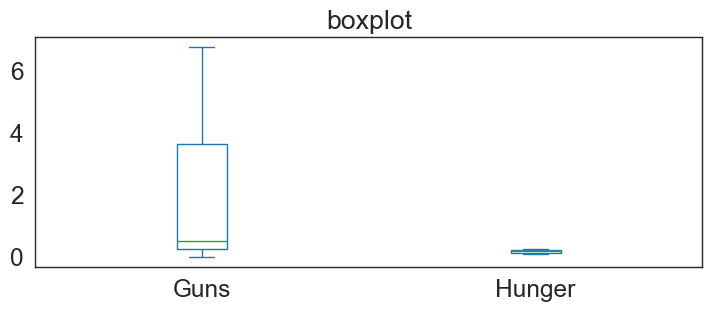

In [198]:
# COMPARE BY BOXPLOT

# GET DATA
gun_boxplot_data = full_data['Number of Shootings'].quantile([0.25,0.5,0.75])   # TODO: change this to gun rate once done
hunger_boxplot_data = full_data['Food Insecurity'].quantile([0.25,0.5,0.75])
boxplots = pd.DataFrame({'Guns': gun_boxplot_data, 'Hunger': hunger_boxplot_data})

# SET FIGURE 
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = boxplots[['Guns','Hunger']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

<Axes: title={'center': 'box'}>

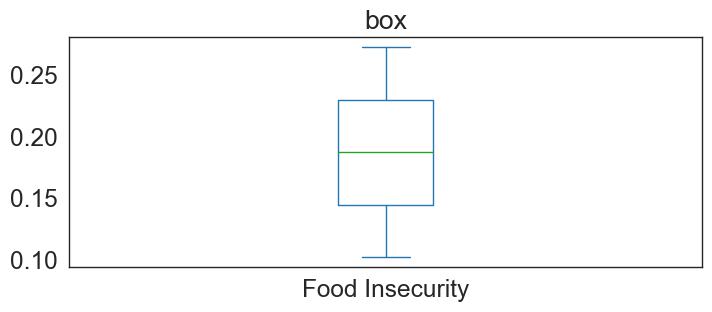

In [ ]:
hunger_boxplot_data = hunger_data['Food Insecurity'].quantile([0.25,0.5,0.75])

hunger_boxplot_data.plot(kind="box",title='box')

### FITTING DISTRIBUTION

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,2.701347,913.014626,-39.853625,inf,0.478261,0.000023
beta,3.203593,740.019367,-32.796114,inf,0.478261,0.000023
lognorm,3.583291,1046.971727,-33.355407,inf,0.478261,0.000023
norm,4.874065,782.048310,-29.415026,inf,0.301357,0.023844
burr,5.110029,3701.777690,-22.056674,inf,0.521739,0.000002


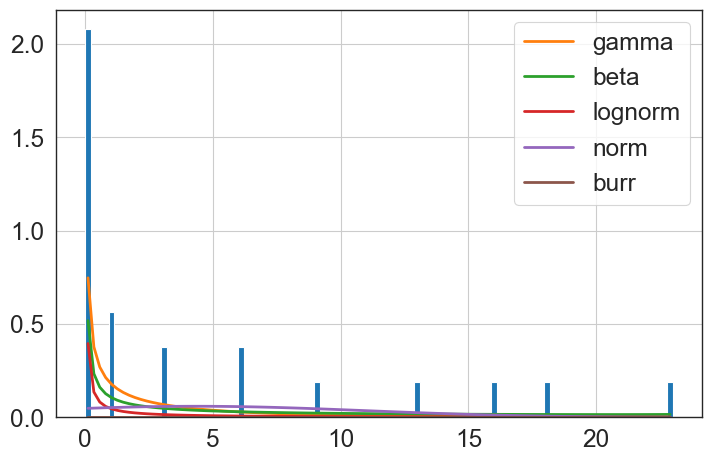

In [ ]:
# IMPORT PACKAGES
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

# FIT THE DISTRIBUTION
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=gun_count, x="count", kind="hist", bins = 100, aspect = 1.5)

gun_count_distri= gun_count["count"].values

f = Fitter(gun_count_distri,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
# FIND THE BEST FITTED DISTRIBUTION
f.get_best(method = 'sumsquare_error')

{'gamma': {'a': 0.4104886180838011,
  'loc': -2.0698224666891094e-27,
  'scale': 6.665745546739703}}

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,5046.547921,-132.648252,122.597478,inf,0.189617,0.416589
beta,5060.427744,-180.701403,122.652409,inf,0.128357,0.855833
lognorm,5388.165846,-133.398954,120.911758,inf,0.175869,0.510513
norm,5503.088429,-162.106913,118.338114,inf,0.169846,0.554433
gamma,5875.403528,-37.218337,122.643152,inf,0.388436,0.003153


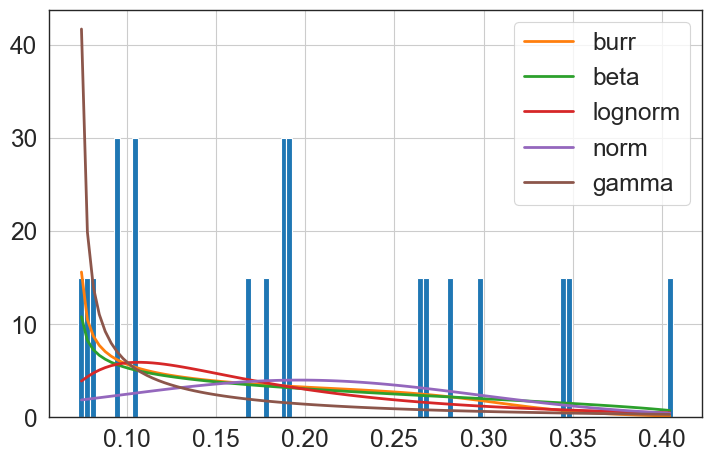

In [ ]:
# FIT THE DISTRIBUTION
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=hunger_data, x="Food Insecurity", kind="hist", bins = 100, aspect = 1.5)

Food_Insecurity = hunger_data["Food Insecurity"].values

f = Fitter(Food_Insecurity,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
# FIND THE BEST FITTED DISTRIBUTION
f.get_best(method = 'sumsquare_error')

{'burr': {'c': 8.43224756013143,
  'd': 0.07584775713535147,
  'loc': 0.07299999999999975,
  'scale': 0.24922439939527444}}